<a href="https://colab.research.google.com/github/diwert-ai/TestTask_PleuralEffSegmentation/blob/master/visualising_ground_truth_and_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colab preset

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
DATASET =     {'train': 'subset.zip'}
INPUT_DIR ='/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/'
OUTPUT_DIR = '/content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/output/'

WORK_DIR='/content/'
EXPERIMENT='test4'
EXPERIMENT_DIR = OUTPUT_DIR + EXPERIMENT+'/'

DATASET_DIR = INPUT_DIR

In [4]:
def copy_dataset(ds_dict, ds_dir, work_dir):
  for record in ds_dict:
    print('copy', ds_dir+ds_dict[record], ' to', work_dir)
    !cp {ds_dir+ds_dict[record]} {work_dir}
    #print('mkdir',work_dir+record)
    #!mkdir {work_dir+record}
    print ('unzip -q ',work_dir+ds_dict[record],' -d ',work_dir)
    !unzip -q  {work_dir+ds_dict[record]} -d {work_dir}
    print ('rm ',work_dir+ds_dict[record])
    !rm {work_dir+ds_dict[record]}


copy_dataset(DATASET,DATASET_DIR, WORK_DIR)
!unzip -q  /content/subset/subset_img.zip -d /content/subset
!unzip -q  /content/subset/subset_masks.zip -d /content/subset
!git clone https://github.com/diwert-ai/TestTask_PleuralEffSegmentation
!cp /content/TestTask_PleuralEffSegmentation/*.py /content
!ls /content/

copy /content/drive/MyDrive/TestTask_PleuralEffusionSegmentation/input/subset.zip  to /content/
unzip -q  /content/subset.zip  -d  /content/
rm  /content/subset.zip
Cloning into 'TestTask_PleuralEffSegmentation'...
remote: Enumerating objects: 72, done.
remote: Counting objects: 100% (72/72), done.
remote: Compressing objects: 100% (55/55), done.
remote: Total 72 (delta 35), reused 40 (delta 14), pack-reused 0
Unpacking objects: 100% (72/72), done.
augment.py  dice_coeff.py  preprocess.py  test.py
config.py   drive	   sample_data	  TestTask_PleuralEffSegmentation
dataset.py  model.py	   subset	  train.py


# Install packages

In [5]:
!pip install --upgrade SimpleITK
!pip install --upgrade segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 52.8 MB 232 kB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 4.0 MB/s 
     |████████████████████████████████| 58 kB 7.0 MB/s 
     |████████████████████████████████| 376 kB 30.2 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=59e8afcd4b82d6f3296db8e19f5d252b39cd2125460b61bb4bdfc591bebfb148
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=f4ecfed457c1438f9e4ab02fad3c2cdd68e276c559b2544a2b10a559c925bd23
  Stored in directory: /root/.cache/pip/wheels/ed/fa/b9/5c82b59d905f95542a192b883c0cc0082407ea2f54beb2f9e6
Successfull

# Imports

In [6]:
import numpy as np
import torch
import torch.utils.data as data
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib.animation as animation
from matplotlib import rc
import gc
from tqdm.notebook import tqdm
import nibabel as nib
import cv2

from config import Config
from preprocess import DataPreprocessor
from dataset import PleuralEffDataset
from model import ModelWrapper
from augment import make_test_augmenter

# Inference and creating animations

In [7]:
def prepare_loaders(debug=False):
    test_df = df_train.query("split=='test'").reset_index(drop=True)
    valid_df = df_train.query("split=='valid'").reset_index(drop=True)
    if debug:
        test_df = test_df.head(Config.batch_size * 1)
        valid_df = valid_df.head(Config.batch_size * 1)
    
    test_dataset = PleuralEffDataset(test_df, transform=test_aug)
    valid_dataset = PleuralEffDataset(valid_df, transform=test_aug)

    p_test_loader = data.DataLoader(test_dataset,
                                    batch_size=Config.batch_size,
                                    num_workers=Config.num_workers,
                                    sampler=data.SequentialSampler(test_dataset),
                                    pin_memory=True)

    p_valid_loader = data.DataLoader(valid_dataset,
                                     batch_size=Config.batch_size,
                                     num_workers=Config.num_workers,
                                     sampler=data.SequentialSampler(valid_dataset),
                                     pin_memory=True)

    return p_test_loader, p_valid_loader

@torch.no_grad()
def do_inference(loader):
    model.eval()
    pbar = tqdm(enumerate(loader), total=len(loader), desc='Inference ')
    pred_3d_mask = None
    for step, (images, _) in pbar:
        images = images.to(Config.device, dtype=torch.float)
        bs = images.size(0)
        y_pred = model(images)
        y_pred = sigmoid(y_pred).round().to(torch.float32).detach().cpu().numpy()
        y_pred = y_pred.reshape(bs, Config.image_size, Config.image_size)
        pred_3d_mask = y_pred if pred_3d_mask is None else np.concatenate((pred_3d_mask, y_pred), axis=0)
    torch.cuda.empty_cache()
    _ = gc.collect()
    return pred_3d_mask


def ground_truth_vs_preds_animation(sample_num, start_slice, stop_slice, mask3d_predicted, prefix=''):
    image3d_path = data_p.images_3d_paths[sample_num]
    mask3d_path = data_p.masks_3d_paths[sample_num]
    image3d = data_p.load_dicom(image3d_path)
    max_slice_num = image3d.shape[0]
    mask3d_gt = nib.load(mask3d_path)
    mask3d_gt = mask3d_gt.get_fdata().transpose(2, 0, 1)

    fig, (ax1, ax2) = plt.subplots(1,2)
    ims = []
    lung_label = image3d_path[data_p.pref_img_len:data_p.pref_img_len + data_p.lung_len]
    ax1.set_title(prefix+' ' + lung_label + ' g. truth')
    ax2.set_title(prefix+' ' + lung_label + ' pred')

    for slice_num in range(min(start_slice, max_slice_num), min(stop_slice, max_slice_num)):
        img, msk_pred, msk_gt = image3d[slice_num], mask3d_predicted[slice_num], mask3d_gt[slice_num]
        msk_gt = cv2.rotate(msk_gt, cv2.ROTATE_90_COUNTERCLOCKWISE)
        im1 = ax1.imshow(img, cmap='bone', animated=True)
        im2 = ax1.imshow(msk_gt, alpha=0.4, animated=True)
        im3 = ax2.imshow(img, cmap='bone', animated=True)
        im4 = ax2.imshow(msk_pred, alpha=0.4, animated=True)
        ims.append([im1, im2, im3, im4])

    ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True, repeat_delay=1000)

    return ani

In [8]:
preprocessed = False

In [9]:
Config.paths = {'root dir': '/content/',
         'exp dir': EXPERIMENT_DIR,
         '3d images dir': '/content/subset/subset/',
         '3d masks dir':'/content/subset/subset_masks/',
         '3d images files': '/content/subset/subset/L*/*/*/*',
         '3d masks files': '/content/subset/subset_masks/L*/*gz',
         'images train': '/content/train/',
         'masks train': '/content/train/masks/'}
if not preprocessed:
  data_p = DataPreprocessor(Config.paths)
  !mkdir {Config.paths['images train']}
  !mkdir {Config.paths['masks train']}
  df_train = data_p.run()
  preprocessed = True
test_aug = make_test_augmenter()
sigmoid = torch.nn.Sigmoid()
test_loader, valid_loader = prepare_loaders(debug=Config.debug)
model = ModelWrapper(pretrained=False)
model.to(Config.device)
model_path = Config.paths['exp dir'] + 'best_valid_[ep_20]_0.6066.bin'
model.load_state_dict(torch.load(model_path))
test_3d_mask = do_inference(test_loader)
valid_3d_mask = do_inference(valid_loader)

slicing 3d masks : 100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


1087: total images saved
1087: total masks saved


Inference :   0%|          | 0/3 [00:00<?, ?it/s]

Inference :   0%|          | 0/4 [00:00<?, ?it/s]

In [10]:
rc('animation', html='jshtml')

In [ ]:
%matplotlib widget

In [12]:
test_num, valid_num = 0, 8

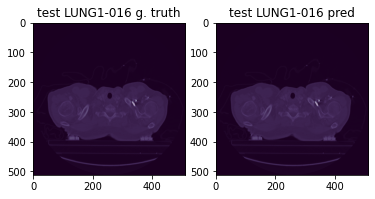

In [13]:
ground_truth_vs_preds_animation(test_num, 0, 200, test_3d_mask, 'test')

In [ ]:
ground_truth_vs_preds_animation(valid_num, 0, 200, valid_3d_mask, 'valid')

<IPython.core.display.Javascript object>